# PyTorch Classification Live Demo

Original version by Sean Robertson <https://github.com/spro/practical-pytorch>  
Adapted from https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

**Goal**: Classify names by language! Examples: Yamaguchi 🇯🇵, Jones 🇬🇧, Asimov 🇷🇺

**Plan**: Design a character-level RNN; for tutorial purposes, we won't use `nn.RNN`.

**Input**: A tensor of (batch size) x (number of characters in name) x 57  
57 is the number of uppercase letters + lowercase letters + permitted symbols `.,;'`

**Output**: Tensor of the likelihoods of languages, dimensions (batch size) x (languages)

**Caveat**: For simplicity, the RNN we write will not support >1 batch size with variable-sized lengths. Additional code will be required (or just use `nn.RNN` and `pack_padded_sequence` which support >1 batch size with variable-sized lengths).

In [1]:
import string, pickle

all_letters = string.ascii_letters + " .,;'"
names_by_language = pickle.load(open("names_by_language.pkl", "rb"))
languages = list(names_by_language.keys())
num_names = sum(len(names) for names in names_by_language.values())

# names_by_language is a dictionary of languages, each with a list of names
print("Languages:", languages, end="\n\n")
print("First 10 English names:", names_by_language["English"][:10], end="\n\n")
print(num_names, "names in total")

Languages: ['English', 'German', 'Japanese', 'Russian']

First 10 English names: ['Abbas', 'Abdi', 'Addison', 'Adlam', 'Ainsworth', 'Aldersley', 'Aldred', 'Aldworth', 'Ali', 'Alldritt']

2800 names in total


## Step 1: Turning Names into Tensors
As mentioned, we want tensors of dimensions (batch size) x (number of characters in name) x 57  
Each character will be represented in one-hot form: `[0, ..., 0, 1, 0, ..., 0]`  
Note that many programmers/researchers, including the author of the original tutorial, prefer to have the batch size as dimension 1, e.g. (...) x (batch size) x ...

In [2]:
import numpy, random
from itertools import cycle, islice

names_array = numpy.zeros((num_names, 99, len(all_letters)), dtype="float32")
languages_array = numpy.zeros((num_names), dtype="long")
name_index = 0

for language_index, language in enumerate(names_by_language.keys()):
    for name in names_by_language[language]:
        for i, letter in enumerate(name):
            try:
                names_array[name_index, i, all_letters.find(letter)] = 1
            except:
                pass
        languages_array[name_index] = language_index
        name_index += 1

print(names_by_language["English"][0])
print(names_array[0, 0:6, :])

Abbas
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0

Next, let's split the array into a train and test set, and convert to tensor

In [3]:
import torch
from sklearn.model_selection import train_test_split

names_array_train, names_array_test, languages_array_train, languages_array_test = \
    train_test_split(names_array, languages_array, test_size=0.1)

names_tensor_train = torch.from_numpy(names_array_train)
languages_tensor_train = torch.from_numpy(languages_array_train)
names_tensor_test = torch.from_numpy(names_array_test)
languages_tensor_test = torch.from_numpy(languages_array_test)

print(names_tensor_train.shape)
print(languages_tensor_train.shape)
print(names_tensor_test.shape)
print(languages_tensor_test.shape)

torch.Size([2520, 99, 57])
torch.Size([2520])
torch.Size([280, 99, 57])
torch.Size([280])


## Step 2: Create Datasets and Data Loaders
You *don't* have to create datasets and data loaders, but it keeps your code clean and there's no reason not to.

In [4]:
from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler

train_dataset = TensorDataset(names_tensor_train, languages_tensor_train)
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=1)
test_dataset = TensorDataset(names_tensor_test, languages_tensor_test)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=1)

## Step 3: Create the Network
Let's represent our RNN by an object class that subclasses `torch.nn.Module`.

In [5]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

# Initialize the RNN
n_hidden = 128
rnn = RNN(len(all_letters), n_hidden, len(languages))

Notice that our RNN takes as input a **hidden state**, and outputs another **hidden state**.  
With PyTorch, **you** define the input(s), output(s), structure, and hyperparameters.  
Let's perform a sanity check and make sure the input(s), output(s), and intermediate states are what you expect. 

In [6]:
# Feed just the 1st letter of the name "Abadi"
input_tensor = torch.from_numpy(names_array)[0:1, 0, :]
hidden_tensor = rnn.initHidden(1)
output_tensor, next_hidden_tensor = rnn(input_tensor, hidden_tensor)

print("Input: ", input_tensor.shape)
print("Hidden:", hidden_tensor.shape)
print("Output:", output_tensor.shape)
print(output_tensor)

Input:  torch.Size([1, 57])
Hidden: torch.Size([1, 128])
Output: torch.Size([1, 4])
tensor([[-1.3180, -1.4967, -1.3843, -1.3550]], grad_fn=<LogSoftmaxBackward>)


## Step 4a: Train the Network
Our loss function, `NLLLoss`, checks a Negative Log Likelihood (NLL) tensor against a target tensor that specifies which index of the NLL tensor should be highest. Example:  
✅ NLL tensor: `[-3, -1, -2]`, target: `[1]`  
❌ NLL tensor: `[-1, -3, -2]`, target: `[1]`

Let's train for **5 epochs**. We will also be performing basic evaluation *alongside* training. This is a good practice because you can then detect **overfitting**, **insufficient learning rate**, and other issues.

In [7]:
from tqdm import tqdm
import matplotlib.pyplot as plt

LEARNING_RATE = 0.01
criterion = nn.NLLLoss()

train_average_losses = []
test_average_losses = []

for epoch_index in tqdm(range(5)):

    # TRAIN

    train_losses = []

    for step_index, batch in enumerate(train_dataloader):

        input_tensor, expected_output = batch
        hidden_tensor = rnn.initHidden(input_tensor.shape[0])

        rnn.zero_grad()

        for i in range(input_tensor.shape[1]):
            if len(torch.nonzero(input_tensor[:, i, :])) > 0:
                output_tensor, hidden_tensor = rnn(input_tensor[:, i, :], hidden_tensor)

        loss = criterion(output_tensor, expected_output)
        loss.backward()

        # Add parameters' gradients to their values, multiplied by learning rate
        for p in rnn.parameters():
            p.data.add_(-LEARNING_RATE, p.grad.data)

        train_losses.append(loss.item())

    train_average_losses.append(sum(train_losses) / len(train_losses))

    # TEST

    test_losses = []

    with torch.no_grad():
        for step_index, batch in enumerate(test_dataloader):

            input_tensor, expected_output = batch
            hidden_tensor = rnn.initHidden(input_tensor.shape[0])

            for i in range(input_tensor.shape[1]):
                if len(torch.nonzero(input_tensor[:, i, :])) > 0:
                    output_tensor, hidden_tensor = rnn(input_tensor[:, i, :], hidden_tensor)

            loss = criterion(output_tensor, expected_output)
            test_losses.append(loss.item())

    test_average_losses.append(sum(test_losses) / len(test_losses))

100%|██████████| 5/5 [00:36<00:00,  7.35s/it]


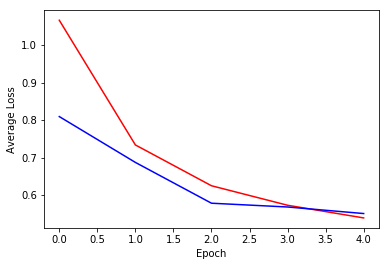

In [8]:
plt.figure()
plt.plot(train_average_losses, "r")
plt.plot(test_average_losses, "b")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.show()

## Step 4b: Add an optimizer
You can use an optimizer included with PyTorch rather than writing your own.  
While the RNN trains here, we'll write this part in VS Code.

## Step 5: Evaluate the Network
There are many metrics for evaluating a classifier, e.g. F1 score, accuracy, etc.  
For this tutorial, we'll create a confusion matrix. **Rows are actual/target languages, columns are predictions.**

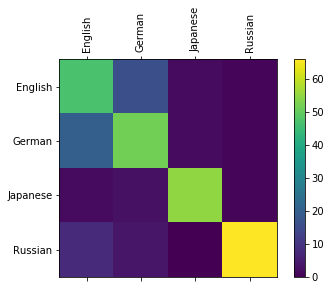

In [9]:
import matplotlib.ticker as ticker

confusion = torch.zeros(len(languages), len(languages))

with torch.no_grad():
    for step_index, batch in enumerate(test_dataloader):
            
        input_tensor, expected_output = batch
        hidden_tensor = rnn.initHidden(input_tensor.shape[0])

        for i in range(input_tensor.shape[1]):
            if len(torch.nonzero(input_tensor[:, i, :])) > 0:
                output_tensor, hidden_tensor = rnn(input_tensor[:, i, :], hidden_tensor)
                _, predicted_output = output_tensor.topk(1)
        for j in range(output_tensor.shape[0]):
            confusion[expected_output[j]][predicted_output[j]] += 1

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + languages, rotation=90)
ax.set_yticklabels([''] + languages)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()